# Equations of motion of a planar floating triple pendulum
Consider a three-link inverted pendulum, where each link is a homogenous rod.
<!--- ![Two-link inverted pendulum](./figures/two-link.png "Two-link inverted pendulum") -->
<img src="./figures/floating-three-link.png" alt="Three-link inverted pendulum" style="width: 300px;"/>
The pendulum moves in the plane
\begin{equation}
y = 0
\end{equation}

We will make use of the sympy.physics.mechanics module to generate the equations of motion.

In [1]:
import numpy as np
import sympy as sy
import sympy.physics.mechanics as me 

## Parameters of the model
To describe the links, we need to define their lengths, $l_i$, masses, $m_i$ and the position of the CoM of each link, in fraction of the length of the link from proximal to distal joint. For the base link, link 0, the proximal joint is the lower joint ("hip joint"). 

## Generalized coordinates
Five generalized coordinates are needed to describe the system, defined as in the figure above. 

## The moment of inertia
The links are assumed to be homogenous rods. If the mass is $m$, the length is $l$ and CoM is at a fraction $\alpha$ from the end point, then the moment of inertial wrt the CoM will be the sum of the inertia for the two parts divided at the CoM:
\begin{equation}
I = \alpha m \frac{(\alpha l)^2}{3} + (1-\alpha)m \frac{\big((1-\alpha)l\big)^2}{3}
  = m\frac{l^2}{3} \big(\alpha^3 + (1-\alpha)^3\big) 
  = m\frac{l^2}{3} \big( 3\alpha(\alpha-1) + 1\big) 
\end{equation}



In [2]:
a = sy.symbols('a')
f = sy.simplify(sy.expand(a**3 + (1-a)**3))
f.subs(a, 0.5) # Check that it is equal to 0.25

0.250000000000000

In [3]:
me.init_vprinting()
m = sy.symbols('m:{}'.format(3))             # Mass of each link
l = sy.symbols('l:{}'.format(3))             # Length of each link
alpha = sy.symbols('alpha:{}'.format(3))     # Position of CoM on link

q = me.dynamicsymbols('q:{}'.format(5))      # Generalized coordinates
qd = me.dynamicsymbols('q:{}'.format(5), 1)  # Generalized speeds

g, t = sy.symbols('g t')                     # Gravity and time

## Inertial frame
We need to define an inertial frame of reference, named $N$, with origin named $O$.

In [4]:
N = me.ReferenceFrame('N')  # Inertial reference frame
O = me.Point('O')           # Origin point
O.set_vel(N, 0)             # Origin's velocity is zero

## Definition of link 0
The point of reference on link 0, and on the complete pendulum is the CoM of link 0. Its position is given by
\begin{equation}
p_0 = \begin{bmatrix} q_3\\q_4 \end{bmatrix}\\
\end{equation}

We also define a frame $B_0$ fixed to link 0 with z-axis pointing in the length direction of the link. The moment of inertia of the link must be defined, using the expression
\begin{equation}
I_x = I_y = m\frac{l_0^2}{3} \big( 3a(a-1) + 1\big). 
\end{equation}
The moment of inertia about the z-axis of $B_0$ will be zero, since the local z-axis is in the direction of the link.

Once the frame, center of mass and moment of inertia are defined, the rigid body object can be created.

In the frame $B_0$, the definition of the proximal ($p_{p_0}$) and distal ($p_{d_0}$) end points as displacement from $p_1$ is straight forward.
\begin{align}
    p_{p_0} &= p_0 - \alpha_0 \,^{B_0}e_z\\
    p_{d_0} &= p_0 + (1-\alpha_0) \, ^{B_1}e_z,
\end{align}
where $^{B_0}e_z$ is a unit vector in the z-direction of frame $B_0$.

In [5]:
p0 = me.Point('CoM_0')
p0.set_pos(O, q[3] * N.x + q[4] * N.z)      # Set the position of CoM    
p0.set_vel(N, qd[3] * N.x + qd[4] * N.z)    # Set the velocity
B0 = N.orientnew('B_0', 'Axis', [q[0], N.y])# Create the frame for link 1, rotated angle q_1 about the y-axis of N
B0.set_ang_vel(N, qd[0] * N.y)              # Set angular velocity

# Define moment of inertia.
IIx = m[0]*l[0]**2/3*(3*alpha[0]*(alpha[0]-1)+1)
II0 = me.functions.inertia(B0, IIx, IIx, 0)

link0 = me.RigidBody('Link_0', p0, B0, m[0], (II0, p0))

prox0 = me.Point('ProxEnd_0')
prox0.set_pos(p0, -alpha[0]*l[0]*B0.z)
vp0 = prox0.v2pt_theory(p0, N, B0)
dist0 = me.Point('DistEnd_0')
dist0.set_pos(p0, (1-alpha[0])*l[0]*B0.z)
vd0 = dist0.v2pt_theory(p0, N, B0)
vd0.express(B0)

## Definition of link 1
Now that the end points of link 0 are known. We can proceed to define link 1. First we define a frame $B_1$ obtained from frame $B_0$ by rotation of an angle $q_1$ about the y-axis.

In [6]:
B1 = B0.orientnew('B_1', 'Axis', [q[1], B0.y])
B1.set_ang_vel(B0, qd[1] * B1.y)

The center of mass of link 1 is found relative to the distal end point of link 0 by going a distance $\alpha_1 l_1$ in the direction of the z-axis of link 1 
\begin{equation}
p_1 = p_{d_0} + \alpha_1 l_1 \, ^{B_1}e_z.
\end{equation}
The velocity is calculated using the two-point expression 
\begin{equation}
\dot{v}_1 = \dot{p}_{d_0} + \omega_{B_1} \times (p_1 - p_{d_0})
\end{equation}

In [7]:
p1 = dist0.locatenew('CoM_1', alpha[1]*l[1]*B1.z)
v1 = p1.v2pt_theory(dist0, N, B1)                         # Set the velocity
v1.express(N)
v1

The moment of inertia of link 1 is found in the same way as for link 0. We define the link as a rigid body, and also define its endpoint.

In [8]:
IIx = m[1]*l[1]**2 / 3 * (3*alpha[1]*(alpha[1]-1)+1)
II1 = me.functions.inertia(B1, IIx, IIx, 0)
link1 = me.RigidBody('Link_1', p1, B1, m[1], (II1, p1))

dist1 = dist0.locatenew('Hands', l[1]*B1.z)

## Definition of link 2
The definition of link 2 is very similar to the definition of link 1. Note only that we must be careful about how we define the orientation of the frame attached to link 2. The choice made here is to let the orientation have local z-axis pointing from the joint to the endpoint, and let zero rotation mean a straight joint with the z-axes of link 0 and link 2 have oposite directions. 

In [9]:
B2 = B0.orientnew('B_2', 'Axis', [np.pi + q[2], B0.y])
B2.set_ang_vel(B0, qd[2] * B2.y)

The center of mass can now be defined relative to the proximal endpoint of link 0

In [10]:
p2 = prox0.locatenew('CoM_2', alpha[2]*l[2]*B2.z)
v2 = p2.v2pt_theory(prox0, N, B2)
v2

Finally, we define the moment of inertia, the rigid body and the endpoint (feet)

In [30]:
IIx = m[2]*l[2]**2 / 3 * (3*alpha[2]*(alpha[2]-1)+1)
II2 = me.functions.inertia(B2, IIx, IIx, 0)
link2 = me.RigidBody('Link_2', p2, B2, m[2], (II2, p2))

dist2 = prox0.locatenew('Feet', l[2]*B2.z)

# Kinetics
## Define the potential energy for each link
The potential energy is simply the height of each link's center of mass. This is obtained by projecting the vector from the origin to the respective CoM onto the vertical direction

In [34]:
link0.set_potential_energy(m[0] * g * p0.pos_from(O).dot(N.z))
link1.set_potential_energy(m[1] * g * p1.pos_from(O).dot(N.z))
link2.set_potential_energy(m[2] * g * p2.pos_from(O).dot(N.z))

## The Lagrangian
The lagrangian is
\begin{equation}
\mathcal{L} = T-U,
\end{equation}
where $T$ is the kinetic energy of the system, and $U$ is the potential energy. These energys are obtained by summing the energies of each link. The sympy.physics.mechanics module has a function for calculating the Lagrangian for a rigid body, when the velocity and the potential energy of the body are defined.

In [35]:
Lag = me.Lagrangian(N, link0) + me.Lagrangian(N, link1) + me.Lagrangian(N, link2)

## Forming the Euler lagrange equations
In the absence of constraints, these equations are given by the expression
\begin{equation}
\frac{d}{dt} \frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = \tau, 
\end{equation}
where $\tau$ are the generalized forces driving the system.

We will assume a constraint in this model requiring the endpoint of link 2, i.e. the feet, to be fixed in the origin. 
\begin{align}
c_1(q) = p_{d_2}(q)_x &= 0\\
c_2(q) = p_{d_2}(q)_z &= 0
\end{align}


In [38]:
constraints = [me.dot(dist2.pos_from(O), N.x), me.dot(dist2.pos_from(O), N.z)]
constraints

With the two constraints, the equations of motion becomes 

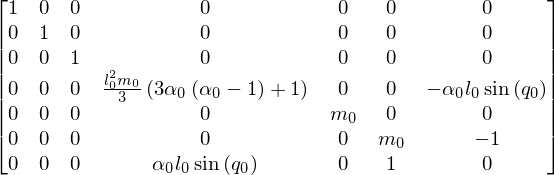

In [44]:
# A simpler case of a single link, link 0
constrSimp = [me.dot(prox0.pos_from(O), N.z)]
LagSimp = me.Lagrangian(N, link0)
qSimp = [q[0], q[3], q[4]]
LM = me.LagrangesMethod(LagSimp, qSimp, hol_coneqs=constrSimp, frame=N)
LM.form_lagranges_equations()
LM.mass_matrix_full

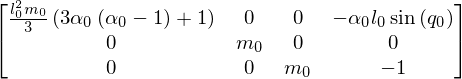

In [47]:
LM.mass_matrix

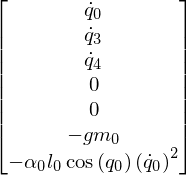

In [50]:
LM.forcing_full

In [51]:
LM.lam_coeffs

## The eqations generated by the LagrangesMethod object
To integrate the equations of motion, we make use of the `mass_matrix_full` matrix and `forcing_full` vector generated. The definition of these are
\begin{equation}
\underbrace{\begin{bmatrix} I_n & 0 & 0\\0 & m_d(q) & \Lambda(q)\\ 0 & m_{cd}(q, \dot{q}) & 0 \end{bmatrix}}_{\text{mass_matrix_full}} \begin{bmatrix} \dot{q} \\ \ddot{q} \\ \lambda \end{bmatrix} = \underbrace{\begin{bmatrix} \dot{q}\\ f_d(q, \dot{q}) \\ f_{cd}(q, \dot{q} \end{bmatrix}}_{\text{forcing_full}}
\end{equation}
where
\begin{equation}
m_{cd}(q, \dot{q}) \ddot{q} = f_{cd} (q, \dot{q}),
\end{equation}
is the equation obtained by differentiating the holonomic constraint equation 
\begin{equation}
c(q,\dot{q}) = 0
\end{equation}
twice w.r.t time, and separating out the matrix in front of $\ddot{q}$. 

## Solving in order to integrate the equations of motion
Write the equations above as 
\begin{equation}
M(q, \dot{q}) \begin{bmatrix} \dot{q} \\ \ddot{q} \\ \lambda \end{bmatrix} = f(q, \dot{q}), 
\end{equation}
and evaluate $M(q, \dot{q})$ and $f(q, \dot{q})$ numerically. Solving the vector equation yields
\begin{equation}
\begin{bmatrix} \dot{q} \\ \ddot{q} \\ \lambda \end{bmatrix} = M(q, \dot{q})^{-1} f(q, \dot{q}). 
\end{equation}
The first two parts of the vector is the time derivative of the state vector
\begin{equation}
x = \begin{bmatrix} q\\\dot{q}\end{bmatrix}
\end{equation}
and the last part is the lagrange multipliers, which gives the constraint forces at the current state.


In [66]:
# Dictionary of parameter values to substitute 
subsdict = { alpha[0]:0.3, alpha[1]:0.5, alpha[2]:0.8, l[0]:0.6, l[1]:0.6, l[2]:1., 
            m[0]:40., m[1]:10., m[2]:30, g:9.79 }
Mmatrix = LM.mass_matrix_full.subs(subsdict)
fvec = LM.forcing_full.subs(subsdict)

# Must substitute symbols for the qd's
uu = me.dynamicsymbols('u:{}'.format(5))  # Generalized speeds
for i in range(5):
    Mmatrix = Mmatrix.subs(qd[i], uu[i])
    fvec = fvec.subs(qd[i], uu[i])
    
qdSimp = [uu[0], uu[3], uu[4]]
dynamicSimp = qSimp + qdSimp    # Make a list of the states

M_func = sy.lambdify(dynamicSimp, Mmatrix)  #callable function to evaluate the mass matrix 
f_func = sy.lambdify(dynamicSimp, fvec)     #callable function to evaluate the forcing vector 

In [96]:
def right_hand_side(x, t):
    """Returns the derivatives of the states.

    Assumes global functions M_func and f_func. Lagrange multipliers will be appended to 
    global list lagrangeMultipliers
    
    Parameters
    ----------
    x : ndarray, [q, qd]
        The current state vector.
    t : float
        The current time.

    Returns
    -------
    dx : ndarray, [qd, qdd]
        The derivative of the state.
    
    """
    qd_qdd_lam = np.ravel(np.linalg.solve(M_func(*x), f_func(*x)))
    
    LagrangeMultipliers.append((t,qd_qdd_lam[6:]))
    #1/0
    return qd_qdd_lam[:6]

In [97]:
import pdb
from scipy.integrate import odeint
x0 = np.array([np.pi/6, 0.1, 0., 0, 0, 0])
timevec = np.linspace(0, 20, 400)
LagrangeMultipliers = []
M_func(*x0)
f_func(*x0)
x = odeint(right_hand_side, x0, timevec)  # Numerical integration

In [98]:
len(LagrangeMultipliers)

In [105]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(211)
plt.plot(timevec, x)
plt.subplot(212)
lagmult = np.array(LagrangeMultipliers)
plt.plot(lagmult[:,0], lagmult[:,1])

plt.show()

In [106]:
np.mean(lagmult[:,1])

In [100]:
from matplotlib import animation
def animate_pendulum(t, states, points, specialpoints, frame, filename=None):
    """Animates the floating 3-pendulum and optionally saves it to file.

    Parameters
    ----------
    t : ndarray, 1D, length m
        Time array.
    generalizedCoords: ndarray, shape(m,5)
        State time history.
    points: list 
        List of endpoints and joints. The order is important, since lines will be drawn between the sequence of
        points. The points should only depend on the state, so all other symbols (parameters of the model) should be 
        substituted with numerical values before calling animate_pendulum.
    frame: The frame in which to plot the pendulum
    filename: string or None, optional
        If true a movie file will be saved of the animation. This may take some time.

    Returns
    -------
    fig : matplotlib.Figure
        The figure.
    anim : matplotlib.FuncAnimation
        The animation.

    """

    # Define functions that will generate the x- and z-coordinates from the list of points
    x_func = sy.lambdify(q, [me.dot(p, frame.x) for p in points])
    z_func = sy.lambdify(q, [me.dot(p, frame.z) for p in points])
    x_func_s = sy.lambdify(q, [me.dot(p, frame.x) for p in specialpoints])
    z_func_s = sy.lambdify(q, [me.dot(p, frame.z) for p in specialpoints])

    #for p in points:
    #    x_funcs.append(sy.lambdify(q, me.dot(p, frame.x)))
    #    z_funcs.append(sy.lambdify(q, me.dot(p, frame.z)))
        
        
    # Set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # set the limits 
    axmin = -5
    axmax = 5
    
    # create the axes
    ax = plt.axes(xlim=(axmin, axmax), ylim=(axmin, axmax), aspect='equal', axisbg='black')
    
    # display the current time
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes, color=(0.5,0.9, 0.9))
    
    
    # blank line for the pendulum
    specialpoints_, = ax.plot([], [], 'o', markersize=10, color=(0.2, 0.8, 0.2))
    points_, = ax.plot([], [], 'o', markersize=6, color=(0.6, 0, 0.6))
    line_, = ax.plot([], [], lw=3, marker='o', markersize=8, color=(0.6, 0, 0))

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        line_.set_data([], [])
        points_.set_data([], [])
        specialpoints_.set_data([], [])
        return time_text, line_, points_, specialpoints_

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f} s'.format(t[i]))
        #x = np.array([xf_(*states[i, :]) for xf_ in x_funcs])
        #z = np.array([zf_(*states[i, :]) for zf_ in z_funcs])
        x = x_func(*states[i, :])
        z = z_func(*states[i, :])
        xs = x_func_s(*states[i, :])
        zs = z_func_s(*states[i, :])
        line_.set_data(x, z)
        points_.set_data(x, z)
        specialpoints_.set_data(xs, zs)
        return time_text,line_,points_, specialpoints_

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=t[-1] / len(t) * 1000, blit=True, repeat=False)
    
    # save the animation if a filename is given
    if filename is not None:
        anim.save(filename, fps=30, writer="avconv", codec='libx264')
        
    return (anim, fig)

qs = np.zeros((x.shape[0], 5))
qs[:,0] = x[:,0] 
qs[:,3] = x[:,1] 
qs[:,4] = x[:,2] 

# Substitute numerical values for the parameters
points = [p_.pos_from(O).subs(subsdict) for p_ in [dist2, p2, p0, dist0, p1, dist1]]
specialpoints = [p_.pos_from(O).subs(subsdict) for p_ in [prox0]]

(anim, fig) = animate_pendulum(timevec, qs, points, specialpoints, 
                               N, filename="falling-simple-constrained-animation.mp4")
plt.show()

In [101]:
from IPython.display import HTML
html = \
"""
<video width="640" height="480" controls>
  <source src="falling-simple-constrained-animation.mp4" type="video/mp4">
Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/Nj3_npq7MZI.
</video>
"""
HTML(html)

## Simulate the full pendulum

In [147]:
# Simulate the full pendulum
#constr = [me.dot(prox0.pos_from(O), N.z)] # Constrain the proximal end of link 0 to move horizontally only
#constr = [me.dot(dist2.pos_from(O), N.z),
#          me.dot(dist2.pos_from(O), N.x)] # Constrain the distal end of link 2 (the feet) to be still
constr = [me.dot(dist1.pos_from(O), N.z)]
Lag = me.Lagrangian(N, link0) + me.Lagrangian(N, link1) + me.Lagrangian(N, link2)
LM = me.LagrangesMethod(Lag, q, hol_coneqs=constr, frame=N)
LM.form_lagranges_equations()
#LM.mass_matrix_full

# Determine the CoM of the linkage
CoMvec = (m[0]*p0.pos_from(O) + m[1]*p1.pos_from(O) + m[2]*p2.pos_from(O)) / (m[0]+m[1]+m[2])
CoM = O.locatenew('CoM', CoMvec)

In [135]:
# Dictionary of parameter values to substitute 
subsdict = { alpha[0]:0.3, alpha[1]:0.5, alpha[2]:0.8, l[0]:0.6, l[1]:0.6, l[2]:1., 
            m[0]:40., m[1]:10., m[2]:30, g:9.79 }
Mmatrix = LM.mass_matrix_full.subs(subsdict)
fvec = LM.forcing_full.subs(subsdict)

# Must substitute symbols for the qd's
uu = me.dynamicsymbols('u:{}'.format(5))  # Generalized speeds
for i in range(5):
    Mmatrix = Mmatrix.subs(qd[i], uu[i])
    fvec = fvec.subs(qd[i], uu[i])
    
dynamicSymbols = q + uu    # Make a list of the states

M_func = sy.lambdify(dynamicSymbols, Mmatrix)  #callable function to evaluate the mass matrix 
f_func = sy.lambdify(dynamicSymbols, fvec)     #callable function to evaluate the forcing vector 

In [136]:
def right_hand_side(x, t):
    """Returns the derivatives of the states.

    Assumes global functions M_func and f_func. Lagrange multipliers will be appended to 
    global list lagrangeMultipliers
    
    Parameters
    ----------
    x : ndarray, [q, qd]
        The current state vector.
    t : float
        The current time.

    Returns
    -------
    dx : ndarray, [qd, qdd]
        The derivative of the state.
    
    """
    qd_qdd_lam = np.ravel(np.linalg.solve(M_func(*x), f_func(*x)))
    
    LagrangeMultipliers.append((t,qd_qdd_lam[10:]))
    #1/0
    return qd_qdd_lam[:10]

In [139]:
import pdb
from scipy.integrate import odeint
x0 = np.array([np.pi/2, 0.1, 0., 0, 0, 0, 0, 0, 0, 0])
timevec = np.linspace(0, 20, 400)
LagrangeMultipliers = []
M_func(*x0)
f_func(*x0)
x = odeint(right_hand_side, x0, timevec)  # Numerical integration

In [148]:
import pendulum_utilities as pu
reload(pu)
qs = x[:,:5]

# Substitute numerical values for the parameters
points = [dist2, prox0, dist0, dist1]
#specialpoints = [p0, p1, p2]
specialpoints = [dist1, CoM]


(anim, fig) = pu.animate_pendulum(timevec, qs, q, subsdict, points, specialpoints, 
                               (O,N), filename="falling-constrained-animation.mp4")
#(anim, fig) = pu.animate_pendulum(timevec, qs, q, subsdict, points, specialpoints, (O,N))
plt.show()

In [142]:
from IPython.display import HTML
html = \
"""
<video width="640" height="480" controls>
  <source src="falling-constrained-animation.mp4" type="video/mp4">
Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/Nj3_npq7MZI.
</video>
"""
HTML(html)

In [146]:
CoM.pos_from(O)

In [116]:
q

In [94]:
x.shape

## Test the kinematics of the system
Let us consider the hands (endpoint of link 1) as the endpoint of interest, and map its cartesian trajectory for some trajectory in the joint space. 

The forward map is simply the position of the endpoint, which we have already defined as $p_{d_1}$. We will calculate the vector from the origin to this point, and plot the z- vs x-coordinates of this vector

In [12]:
import matplotlib.pyplot as plt
# %matplotlib notebook
vEndpoint = dist1.pos_from(O)

# Substitute numerical values for the kinematic parameters
subsdict = {alpha[0]:0.3, l[0]:2., l[1]:1., l[2]:1.}
vEndpointSubs = vEndpoint.subs(subsdict)

epX = me.dot(vEndpointSubs, N.x)
epZ = me.dot(vEndpointSubs, N.z)

def fwdmap(qn):
    return sy.list2numpy([epX.subs(q[0], qn[0]).subs(q[1], qn[1]).subs(q[2], qn[2]).subs(q[3], qn[3]).subs(q[4], qn[4]), 
                          epZ.subs(q[0], qn[0]).subs(q[1], qn[1]).subs(q[2], qn[2]).subs(q[3], qn[3]).subs(q[4], qn[4])], 
                          dtype=np.float64)

NN = 400
qs = np.zeros((5,NN))
qs[1,:] = np.linspace(0,34*np.pi, NN) 
qs[0,:] = np.linspace(0,6.2*np.pi, NN) 

eptraj = np.array([fwdmap(q_) for q_ in qs.T])

plt.figure()
plt.plot(eptraj[:,0], eptraj[:,1])
plt.axis('equal')
plt.show()


## Animating the mechanism


In [25]:
from matplotlib import animation
def animate_pendulum(t, states, points, frame, filename=None):
    """Animates the floating 3-pendulum and optionally saves it to file.

    Parameters
    ----------
    t : ndarray, 1D, length m
        Time array.
    generalizedCoords: ndarray, shape(m,5)
        State time history.
    points: list 
        List of endpoints and joints. The order is important, since lines will be drawn between the sequence of
        points. The points should only depend on the state, so all other symbols (parameters of the model) should be 
        substituted with numerical values before calling animate_pendulum.
    frame: The frame in which to plot the pendulum
    filename: string or None, optional
        If true a movie file will be saved of the animation. This may take some time.

    Returns
    -------
    fig : matplotlib.Figure
        The figure.
    anim : matplotlib.FuncAnimation
        The animation.

    """

    # Define functions that will generate the x- and z-coordinates from the list of points
    x_func = sy.lambdify(q, [me.dot(p, frame.x) for p in points])
    z_func = sy.lambdify(q, [me.dot(p, frame.z) for p in points])

    #for p in points:
    #    x_funcs.append(sy.lambdify(q, me.dot(p, frame.x)))
    #    z_funcs.append(sy.lambdify(q, me.dot(p, frame.z)))
        
        
    # Set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # set the limits 
    axmin = -5
    axmax = 5
    
    # create the axes
    ax = plt.axes(xlim=(axmin, axmax), ylim=(axmin, axmax), aspect='equal', axisbg='black')
    
    # display the current time
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes, color=(0.5,0.9, 0.9))
    
    
    # blank line for the pendulum
    points_, = ax.plot([], [], 'o', markersize=6, color=(0.6, 0, 0.6))
    line_, = ax.plot([], [], lw=3, marker='o', markersize=8, color=(0.6, 0, 0))

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        line_.set_data([], [])
        points_.set_data([], [])
        return time_text, line_, points_

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f} s'.format(t[i]))
        #x = np.array([xf_(*states[i, :]) for xf_ in x_funcs])
        #z = np.array([zf_(*states[i, :]) for zf_ in z_funcs])
        x = x_func(*states[i, :])
        z = z_func(*states[i, :])
        line_.set_data(x, z)
        points_.set_data(x, z)
        return time_text,line_,points_

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=t[-1] / len(t) * 1000, blit=True, repeat=False)
    
    # save the animation if a filename is given
    if filename is not None:
        anim.save(filename, fps=30, writer="avconv", codec='libx264')
        
    return (anim, fig)

In [27]:
NN = 400
qs = np.zeros((5,NN))
qs[2,:] = np.linspace(0,4*np.pi, NN) 
qs[1,:] = np.linspace(0,3*np.pi, NN) 
qs[0,:] = np.linspace(0,2*np.pi, NN) 
states = qs.T

# Substitute numerical values for the parameters
subsdict = {alpha[0]:0.3, alpha[1]:0.5, alpha[2]:0.8, l[0]:2., l[1]:1., l[2]:1.5}
points = [p_.pos_from(O).subs(subsdict) for p_ in [dist2, p2, prox0, p0, dist0, p1, dist1]]

timevec = np.linspace(0, 20, NN)

(anim, fig) = animate_pendulum(timevec, states, points, B1, filename="test-animation.mp4")
plt.show()

In [29]:
from IPython.display import HTML
html = \
"""
<video width="640" height="480" controls>
  <source src="test-animation.mp4" type="video/mp4">
Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/Nj3_npq7MZI.
</video>
"""
HTML(html)

In [ ]:
me.dot(vEndpointSubs, N.x)

In [ ]:
import numpy as np
import sympy as sy
%load_ext autoreload
%autoreload 2

In [ ]:
# In the implementation, we will make the model more general, by allowing the moment of inertia about the 
# respective center of mass to be specified. Also, the position of the CoM from the pivot of each link
# is given as a variable 0 < alpha_i <= 1. So, alpha_i=1 means that the CoM of the link is at the end of the link.

q1, q2, q3, q4, qd1, qd2, qd3, qd4 = sy.symbols('q1, q2, q3, q4, qd1, qd2, qd3, qd4', real=True)
qdd1, qdd2, qdd3, qdd4 = sy.symbols('qdd1, qdd2, qdd3, qdd4', real=True)
g, m1, m2, l1, l2, I1, I2, a1, a2 = sy.symbols('g, m1, m2, l1, l2, I1, I2, alpha1, alpha2', real=True, positive=True)
tau1, tau2, Fx, Fy = sy.symbols('tau1, tau2, Fx, Fy', real=True)


q = sy.Matrix([[q1],[q2],[q3], [q4]])
qd = sy.Matrix([[qd1],[qd2],[qd3], [qd4]])
qdd = sy.Matrix([[qdd1],[qdd2],[qdd3], [qdd4]])
tau = sy.Matrix([])
c1 = sy.cos(q1)
s1 = sy.sin(q1)
c12 = sy.cos(q1+q2)
s12 = sy.sin(q1+q2)

p0 = sy.Matrix([[q3 +a1*l1*s1],[q4+a1*l1*c1]])
p2 = sy.Matrix([[q3 +l1*s1 + a2*l2*s12],[q4+l1*c1 + a2*l2*c12]])
V1 = sy.Matrix([[a2*l1*c1, 0, 1, 0],[-a2*l1*s1, 0, 0, 1]])
pd1 = V1*qd
V2 = sy.Matrix([[l1*c1+a2*l2*c12, a2*l2*c12, 1, 0 ],[-l1*s1-a2*l2*s12, -a2*l2*s12, 0, 1]])
pd2 = V2*qd
Omega1 = sy.Matrix([[1, 0, 0 , 0]])
w1 = Omega1*qd
Omega2 = sy.Matrix([[1, 1, 0 , 0]])
w2 = Omega2*qd

H = m1*V1.T*V1 + m2*V2.T*V2 + I1*Omega1.T*Omega1 + I2*Omega2.T*Omega2

T = 0.5*qd.T*H*qd
U = sy.Matrix([m1*g*p0[1] + m2*g*p2[1]])

# The equations of motion on manipulator form
C = sy.zeros(4,4)
G = sy.zeros(4,1)

for i in range(4):
    qi = q[i]
    Hi = H[:,i]
    Gammai = Hi.jacobian(q)*qd
    ddtdLdqidot = Hi.T*qdd + Gammai.T*qd
    dHdqi = H.diff(qi)
    Di = 0.5*dHdqi*qd
    Gi = U.diff(qi)
    dLdqi = Di.T*qd - Gi
    #lhs1 = ddtdLdq1dot - dLdq1
    # Form the terms for the manipulator form
    Ci = Gammai - Di
    C[i,:] = Ci.T
    G[i] = Gi

#dd

lhs = H*qdd + C*qd + G


In [ ]:
## Verify calculations by comparing to equations of motion given explicitly in Tedrake 2009
Htest = H.subs(I1,0).subs(I2,0).subs(a1,1).subs(a2,1)
Ctest = C.subs(I1,0).subs(I2,0).subs(a1,1).subs(a2,1).subs(qd3,0).subs(qd4,0)
Gtest = G.subs(I1,0).subs(I2,0).subs(a1,1).subs(a2,1).subs(qd3,0).subs(qd4,0)

print "H"
sy.pretty_print(sy.trigsimp(Htest[0,0]))
sy.pretty_print(sy.trigsimp(Htest[1,0]))
sy.pretty_print(sy.trigsimp(Htest[1,1]))
# OK!

print "C"
sy.pretty_print(sy.trigsimp(Ctest[0,0])*qd[0] + sy.trigsimp(Ctest[0,1])*qd[1])
# OK!

print "G"
sy.pretty_print(sy.trigsimp(Gtest))
# OK!


# Center of mass dynamics
The location of center of mass is
\begin{equation}
c = \begin{bmatrix} c_x\\c_z \end{bmatrix} = \frac{m_1}{m_1+m_2} p_1(q) + \frac{m_2}{m_1+m_2} p_2(q).
\end{equation}

Newton's equations of motion tell us that the acceleration of the CoM equals the sum of external forces acting on the system, and the rate of change of angular momentum of the body w.r.t CoM equals the sum of torques of the external forces w.r.t the CoM.

Let $L$ denote the angular momentum of the body, let 
\begin{equation}
F = \begin{bmatrix} F_a\\M_a \end{bmatrix}
\end{equation}
be the external force and torque applied at the base joint (feet), and 
\begin{equation}
a(q) = \begin{bmatrix} a_x\\ a_z \end{bmatrix} = p_b(q) - c(q)
\end{equation}
be the vector from the CoM to the base joint where the force is applied. The torque due to the force $F_a$ w.r.t CoM is then
\begin{equation}
    M_y = a_zF_x - a_xF_z
\end{equation}

The equations of motion can then be written
\begin{equation}
\begin{bmatrix}  D_1\\ D_2 \end{bmatrix} F = \begin{bmatrix} (m_1+m_2)\ddot{c} - (m_1+m_2)g\\ \dot{L} \end{bmatrix},
\end{equation}
where
\begin{equation}
D_1 = \begin{bmatrix} I & 0 \end{bmatrix}
\end{equation}
\begin{equation}
D_2 = \begin{bmatrix} a_z & -a_x & 1 \end{bmatrix}.
\end{equation}
The vector $g$ is the gravity vector which points in the negative $z$-direction, i.e.
\begin{equation}
g = \begin{bmatrix} 0\\-9.8 \end{bmatrix}
\end{equation}

Introducing
\begin{equation}
K(q) = \begin{bmatrix} D_1\\ D_2(q) \end{bmatrix},
\end{equation}
and
\begin{equation}
u = \begin{bmatrix} (m_1+m_2)\ddot{c} - (m_1+m_2)g\\ \dot{L} \end{bmatrix},
\end{equation}
the equation of motion of the CoM can be written compactly
\begin{equation}
K(q)F = u.
\end{equation}



In [ ]:
Fa,Ma,L,Ld,cddx,cddz = sy.symbols('Fa, Ma, L, Ld, cddx, cddz', real=True)
m = m1+m2
pc = m1/m * p0 + m2/m * p2
pb = sy.Matrix([q3,q4]) # Column vector
pa = pb-pc
D1 = sy.Matrix([[1, 0, 0], [0, 1, 0]])
D2 = sy.Matrix([[pa[1], -pa[0], 1]])
gvec = g*sy.Matrix([0,-1])

# Abbreviation as in Stephens and Atkeson 2010: KF = u
K = D1.col_join(D2)
u = (m*sy.Matrix([cddx, cddz])-m*gvec).col_join(sy.Matrix([[Ld]]))


# Determining allowable external forces that give desired CoM acceleration
The right hand side of the equations of motion
\begin{equation}
u = \begin{bmatrix} (m_1+m_2)\ddot{c} - (m_1+m_2)g\\ \dot{L} \end{bmatrix},
\end{equation}
consists of known quantities ($m_1$, $m_2$, $g$) and specified, desired quantities ($\ddot{c}$ and $\dot{L}$).
On the left hand side, the matrix $K(q)$ depends on the current configuration $q$, since
\begin{equation}
K(q) = \begin{bmatrix} D_1\\ D_2(q) \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0\\0 & 1 & 0\\ a_z(q) & -a_x(q) & 1 \end{bmatrix}.
\end{equation}


## Constraints
Not all forces found as solutions to 
\begin{equation}
K(q)F = u
\end{equation}
are allowed, since they must satisfy constraints on the support polygon (base of support) and friction.
<!--- ![Two-link inverted pendulum](./figures/two-link.png "Two-link inverted pendulum") -->
<img src="./figures/BoS-constraints.png" alt="Constraints due to the Base of Support" style="width: 600px;"/>
For the base of support, the constraint takes the form
\begin{equation}
-d_x^- \le -\frac{M_y}{F_z} \le d_x^+,
\end{equation}
OBS: In Stephens and Atkeson eq (10) there is no minus sign in front of $d_x^-$, meaning it must be a negative number. Here, we take it to be a distance, hence positive.

$d_x^-$ is the lower limit of the base of support, and $d_x^+$ is the upper limit. This constraint is equivalent to
\begin{equation}
\frac{M_y}{F_z} \le d_x^-
\end{equation}
\begin{equation}
-\frac{M_y}{F_z} \le d_x^+,
\end{equation}
which can be written 
\begin{equation}
M_y - F_z d_x^- \le 0
\end{equation}
\begin{equation}
-M_y - F_z d_x^+ \le 0
\end{equation}


The constraint of friction in 3D is nonlinear. It states that the relative magnitude of the horizontal to the vertical force must be less than a fricion coefficient $\mu$ specific for the interface between feet and ground.
\begin{equation}
\left| \frac{\sqrt{F_x^2 + F_y^2}}{F_z} \right | \le \mu
\end{equation}
In the 2D case the constraint is linear, and can be written
\begin{equation}
\left| \frac{F_x}{F_z} \right | \le \mu,
\end{equation}
or
\begin{equation}
\frac{F_x}{F_z} \le \mu
\end{equation}
\begin{equation}
-\frac{F_x}{F_z} \le \mu
\end{equation}
which can be written
\begin{equation}
F_x - \mu F_z \le 0
\end{equation}
\begin{equation}
-F_x - \mu F_z \le 0.
\end{equation}
where it is assumed that $F_z$ is positive.

The constraints can be written as the linear inequality
\begin{equation}
BF \le 0,
\end{equation}
where
\begin{equation}
B = \begin{bmatrix} 0 & -d_x^- & 1\\ 0 & -dx^+ &-1\\ 1 & -\mu & 0\\ -1 & -\mu & 0 \end{bmatrix}
\end{equation}

# Optimization problem
Determining the required contact forces can be formulated as the constrainted optimization problem (Stephens and Atkeson eq (15))
\begin{equation}
\hat{F} = \arg \min_F (KF - u)^T(KF-u) + F^TWF,
\end{equation}
\begin{equation}
\text{s.t.} \quad BF \le 0,
\end{equation}
The matrix $W$ can be used to weight the force differently, for instance to penalize horizontal forces or torques at the ankle joint. 

The criterion can be rewritten as 
\begin{equation}
f(F) =  (KF - u)^T(KF-u) + F^TWF = F^T(W + K^TK)F - 2u^T K F + u^Tu,
\end{equation}
the last term does not depend on $F$ and can be ignored in the optimization. This gives the quadratic programming problem (QP)
\begin{equation}
 \text{minimize} \quad F^T(W + K^TK)F - 2u^T K F,
\end{equation}
\begin{equation}
\text{s.t.} \quad BF \le 0.
\end{equation}


In [ ]:
import cvxopt as cvx

dxmin,dxplus,mu = sy.symbols('dxmin, dxplus, mu')
# The general formula for the QP when using cvxopt is
# minimize  0.5 x^T Q x + p x,
# subject to G x <= h,     B x z= 0 here
#            A x = b       not used here
# Determine matrices for the QP
lmbda = 0.001  # Used to make sure the weighting matrix W is not too big wrt K^TK
WW = sy.Matrix([[1, 0, 0],[0, 1, 0],[0,0,1]])*lmbda
QQ = 2*(WW + K.T*K)
pp = (-2*u.T*K).T
GG = sy.Matrix([[0, -dxmin, 1], [0, -dxplus, -1], [1, -mu, 0], [-1, -mu, 0]])
hh = sy.Matrix([0,0,0,0])

# Numerical example using cvxopt
#q1_ = np.pi/12
q1_ = 0
q2_ = 0
q3_ = 0.5
q4_ = 0.5
cdd = 1 # Magnitude of desired acceleration
cddx_ = -1.
cddz_ = 0.
Ld_ = 200.

g_ = 9.799
m1_ = 35.
m2_ = 40.
l1_ = 1.
l2_ = 1.
alpha1_ = 1.
alpha2_ = 1.
mu_ = 0.6
dxmin_ = 0.08
dxplus_ = 0.16

# Substitue numerical values
QQ_ = QQ.subs(q1, q1_).subs(q2, q2_).subs(m1, m1_).subs(m2, m2_).subs(l1, l1_).subs(l2, l2_).subs(a1, alpha1_)
QQ_ = QQ_.subs(a2, alpha2_)
pp_ = pp.subs(q1, q1_).subs(q2, q2_).subs(m1, m1_).subs(m2, m2_).subs(l1, l1_).subs(l2, l2_).subs(a1, alpha1_)
pp_ = pp_.subs(a2, alpha2_).subs(cddx, cddx_).subs(cddz, cddz_).subs(Ld, Ld_).subs(g, g_)
GG_ = GG.subs(dxmin, dxmin_).subs(dxplus, dxplus_).subs(mu, mu_)
sy.pretty_print(QQ_)
sy.pretty_print(pp_)
sy.pretty_print(GG_)

# Convert to numpy
QQn = sy.matrix2numpy(QQ_)
ppn = sy.matrix2numpy(pp_)
GGn = sy.matrix2numpy(GG_)
hhn = sy.matrix2numpy(hh)

# And then to cvxopt matrices
print QQn.dtype
QQc = cvx.matrix(QQn.astype(np.float64))
ppc = cvx.matrix(ppn.astype(np.float64))
GGc = cvx.matrix(GGn.astype(np.float64))
hhc = cvx.matrix(hhn.astype(np.float64))

sol=cvx.solvers.qp(QQc, ppc, GGc, hhc)
# Try also unconstrained problem
solU = cvx.solvers.qp(QQc, ppc)
print "Constrained solution"
print sol['x']
print "Unconstrained solution"
print solU['x']



### Verify solution to required contact forces, using standard single pendulum model

If the body is static in a certain position, and we require it to be static, then the desired acceleration is zero $\ddot{c}= 0$ and the desired change in angular momentum is also zero, $\dot{L} = 0$. 

The force and momentum at the contact point (foot) must then be such that they balance the force of gravity, while achieving no acceleration of the body. The horizontal force must be zero, and the reaction force must go through the center of mass. This means that the center of pressure is directly below the center of mass. 

The result from the optimization is a vector $\hat{F}$ consisting of the horizontal and vertical forces, and the moment about the $y$ - - axis. 
\begin{equation}
\hat{F} = \begin{bmatrix} \hat{F}_x\\ \hat{F}_z \\ \hat{M}_y \end{bmatrix}
\end{equation}

Consider a person (or robot) standing facing in the $x$ - direction. If $\hat{M}_y>0$, we must have a center of pressure which is behind the ankle joint. The person is leaning backwards, and the distance must be
\begin{equation}
\hat{d}_x = \frac{\hat{M}_y}{\hat{F}_z}.
\end{equation}
This must be the same as the horizontal distance between the CoM and the base joint.

Let's check this below.


In [ ]:
import matplotlib.pyplot as plt
import double_pendulum as dpu

In [ ]:
reload(dpu)
# Set desired accelerations to zero
# Numerical example using cvxopt
#q1_ = np.pi/12
alpha1_ = 0.7
alpha2_ = 0.6
q1_ = -np.pi/12
q2_ = np.pi/4
q3_ = 0.5
q4_ = 0.5
# Desired acceleration
cddx_ = 2.
cddz_ = 0.
Ld_ = 0.

# Substitue numerical values
QQ_ = QQ.subs(q1, q1_).subs(q2, q2_).subs(m1, m1_).subs(m2, m2_).subs(l1, l1_).subs(l2, l2_).subs(a1, alpha1_)
QQ_ = QQ_.subs(a2, alpha2_)
pp_ = pp.subs(q1, q1_).subs(q2, q2_).subs(m1, m1_).subs(m2, m2_).subs(l1, l1_).subs(l2, l2_).subs(a1, alpha1_)
pp_ = pp_.subs(a2, alpha2_).subs(cddx, cddx_).subs(cddz, cddz_).subs(Ld, Ld_).subs(g, g_)
GG_ = GG.subs(dxmin, dxmin_).subs(dxplus, dxplus_).subs(mu, mu_)

# Convert to numpy
QQn = sy.matrix2numpy(QQ_, dtype=np.float64)
ppn = sy.matrix2numpy(pp_, dtype=np.float64)
GGn = sy.matrix2numpy(GG_, dtype=np.float64)
hhn = sy.matrix2numpy(hh, dtype=np.float64)

# And then to cvxopt matrices
QQc = cvx.matrix(QQn)
ppc = cvx.matrix(ppn)
GGc = cvx.matrix(GGn)
hhc = cvx.matrix(hhn)

sol=cvx.solvers.qp(QQc, ppc, GGc, hhc)
# Try also unconstrained problem
solU = cvx.solvers.qp(QQc, ppc)
print "Constrained solution"
print sol['x']
print "Unconstrained solution"
print solU['x']

# Verify that My/Fz equals distance in x-dir between CoM and base joint
sy.pretty_print(pa)
pa_ = pa.subs(q1, q1_).subs(q2, q2_).subs(q3, q3_).subs(q4, q4_).subs(a1, alpha1_).subs(a2, alpha2_)
pa_ = pa_.subs(m1, m1_).subs(m2, m2_).subs(l1, l1_).subs(l2, l2_)
pa_n = sy.matrix2numpy(pa_, dtype=np.float64)

print "My/Fz - ax = %f" % (sol['x'][2]/sol['x'][1] - pa_n[0])

Fx = sol['x'][0]
Fz = sol['x'][1]
My = sol['x'][2]

#Fx = solU['x'][0]
#Fz = solU['x'][1]
#My = solU['x'][2]

dp = dpu.DoublePendulum()
dp.L1 = l1_
dp.L2 = l2_
dp.a1 = alpha1_
dp.a2 = alpha2_
dp.m1 = m1_
dp.m2 = m2_
animation = dpu.DoublePendulumAnimation(dp)
animation.init_dp(q1_, q2_, q3_, q4_, Fx, Fz, My)

plt.show()


In [ ]:
# Check solution
Fhat = sy.Matrix(solU['x'])
K_ = K.subs(q1, q1_).subs(q2, q2_).subs(m1, m1_).subs(m2, m2_).subs(l1, l1_).subs(l2, l2_).subs(a1, alpha1_)
K_ = K_.subs(a2, alpha2_)
# Convert to numpy
Kn = sy.matrix2numpy(K_, dtype = np.float64)
print "det K = %f" % np.linalg.det(Kn)
print "uhat = "
uhat = K_*Fhat

sy.pretty_print(uhat)
un = sy.matrix2numpy(u.subs(m1, m1_).subs(m2,m2_).subs(cddx, cddx_).subs(cddz, cddz_).subs(Ld, Ld_).subs(g, g_),
                    dtype = np.float64)
print "u_n ="
print un
Fn = np.linalg.solve(Kn, un)
print "F_n ="
print Fn

uhatn = np.dot(Kn, Fn)
print "uhat_n = "
print uhatn

print "K_ = "
sy.pretty_print(K_)
print "K'*K = "
sy.pretty_print(K_.T*K_)


In [ ]:
sy.pretty_print(c)

sy.pretty_print(u)
sy.pretty_print(K)
sy.pretty_print(u.subs(m1, m1_).subs(m2,m2_).subs(cddx, cddx_).subs(cddz, cddz_).subs(Ld, Ld_).subs(g, g_))


# Jacobian of base joint
The position of the base joint (ankle joint) is simply
\begin{equation}
p_b = \begin{bmatrix} 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1\end{bmatrix} \begin{bmatrix} q_1\\q_2\\q_3\\q_4\end{bmatrix}
\end{equation}
and the velocity
\begin{equation}
v_b = \begin{bmatrix} 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1\end{bmatrix} \begin{bmatrix} \dot{q}_1\\\dot{q}_2\\\dot{q}_3\\\dot{q}_4\end{bmatrix}
\end{equation}
The feet are asumed to be parallell to the ground, so the orientation is constant
\begin{equation}
\omega_b = 0
\end{equation}

Thus, the Jacobian is the matrix $J$ that transforms generalized velocities into velocity of the base joint 
\begin{equation}
\begin{bmatrix} v_b\\\omega_b \end{bmatrix} = J \dot{q} = \begin{bmatrix} 0 & I_2\\0 & 0\end{bmatrix} \dot{q}. 
\end{equation}

# Constraint equation for the generalized coordinates
The equations of motion for the mechanism must be accompanied by a constraint equation obtained by differentiating the equation
\begin{equation}
\begin{bmatrix} v_b\\\omega_b \end{bmatrix} = J \dot{q} = \begin{bmatrix} 0 & I_2\\0 & 0\end{bmatrix} \dot{q}. 
\end{equation}
This leads to 
\begin{equation}
\begin{bmatrix} \dot{v}_b\\\dot{\omega}_b \end{bmatrix} = J \ddot{q} + \dot{J}\dot{q}. 
\end{equation}
Specifically, in our case
\begin{equation}
\begin{bmatrix} \dot{v}_b\\\dot{\omega}_b \end{bmatrix} = \begin{bmatrix} 0 & I_2\\0 & 0\end{bmatrix} \ddot{q}. 
\end{equation}
The constraint equation simply tells us that the acceleration in the last two generalized coordinates (the position of the base) must be zero, since we assume that the feet are firmly on the ground. 


# Dynamic balance force control
We have worked out most of the preliminary detials, and are now ready to derive the dynamics balance force control.

## Augmented equations of motion
The equations of motion of the mechanism with the constraint equation is
\begin{equation}
H(q)\ddot{q} + C(q, \dot{q})\dot{q} + G(q) = S\tau + J^T(q)F
\end{equation}
\begin{equation}
J\ddot{q} + \dot{J}\dot{q} = \ddot{P}_b,
\end{equation}
where $\ddot{P}_b$ is the translational and angular acceleration of the base (the feet). The matrix $S$ picks the elements of $\tau$ that are actuated. In our case, since only the joints are actuated, not the position of the feet, gives
\begin{equation}
S = \begin{bmatrix} I_2 & 0\\ 0 & 0 \end{bmatrix}.
\end{equation}
The transpose of the Jacobian $J^T(q)$ relates the external force acting at the feet to forces at the joints. In our case this becomes
\begin{equation}
J^T(q) = \begin{bmatrix} 0 & 0\\ I_2 & 0\end{bmatrix},
\end{equation}
and is not dependent on the generalized coordinates $q$. The transposed Jacobian tells us that of the forces and moment acting on the feet 
\begin{equation}
F = \begin{bmatrix} F_x\\F_z\\M_y \end{bmatrix},
\end{equation}
none give (or require) any torques at the joints. Only the generalized coordinates corresponding to the position of the feet are affected, and only by the forces, not by $M_y$.  

The equations of motion of the mechanism are augmented with the equations of motion of the center of mass. The unknowns in this equation are the generalized accelerations $\ddot{q}$, the generalized forces $\tau$ and the external force $F$. The state of the robot, i.e. $q$ and $\dot{q}$, is assumed to be known. This gives
\begin{equation}
\begin{bmatrix}
H(q) &  -S & -J^T\\
J(q) & 0 & 0\\
0 & 0 & D_1\\
0 & 0 & D_2
\end{bmatrix}
\begin{bmatrix} \ddot{q} \\ \tau \\ F \end{bmatrix}
= \begin{bmatrix} -N(q, \dot{q}) \\ \ddot{P}_{\text{des}} - \dot{J}\dot{q} \\ m\ddot{c}_{\text{des}} + F_g, \\ \dot{L}_{\text{des}} \end{bmatrix}
\end{equation}
where $N(q, \dot{q})=C(q,\dot{q})\dot{q} + G(q)$. 

Now, if we solve separately for $F$ using the formulation as an QP in the previous section, we can simplify the equations to 
\begin{equation}
\begin{bmatrix}
H(q) & -S\\
J & 0
\end{bmatrix}
\begin{bmatrix} \ddot{q} \\ \tau \end{bmatrix}
= \begin{bmatrix} -N(q, \dot{q}) + J^T\hat{F}\\ -\dot{J}\dot{q} \end{bmatrix}
\end{equation}

In the case of our floating double pendulum, this equation becomes
\begin{equation}
\begin{bmatrix}
H(q) & -\begin{bmatrix} I_2 & 0\\ 0 & 0 \end{bmatrix}\\
\begin{bmatrix} 0 & I_2\\0 & 0\end{bmatrix} & 0
\end{bmatrix}
\begin{bmatrix} \ddot{q} \\ \tau \end{bmatrix}
= \begin{bmatrix} -N(q, \dot{q}) + \begin{bmatrix} 0 & 0\\ I_2 & 0\end{bmatrix}\hat{F}\\ 0  \end{bmatrix}
\end{equation}

The system of equation can be written 
\begin{equation}
Dz = f,
\end{equation}
where $D$ is $8 \times 8$. It can be solved, with regularization matrix $W$ with a pseudo-inverse
\begin{equation}
z = (D^TD + W)^{-1}D^Tf.
\end{equation}

The solution is 
\begin{equation}
z = \begin{bmatrix} \ddot{q} \\ \tau_{\text{dbfc}} \end{bmatrix},
\end{equation}
where $\tau_{\text{dbfc}}$ are the generalized torques used for feedback control. 

In [ ]:
# Let's implement the equations and test a few things. 
N = C*qd + G
J = sy.Matrix([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
S = sy.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
Fxs, Fzs, Mys = sy.symbols('Fx, Fz, My') 
Fhat = sy.Matrix([Fxs, Fzs, Mys])
Dr1 = H.row_join(-S)
Dr2 = J.row_join(sy.zeros(3,4))
D = Dr1.col_join(Dr2)
f1 = -N+J.T*Fhat
f = f1.col_join(sy.zeros(3,1))

# Substitue numerical values
qd1_ = 0.1
qd2_ = 0.2
qd3_ = 0
qd4_ = 0
I1_ = 1
I2_ = 2
numvals = {q1:q1_, q2:q2_, q3:q3_, q4:q4_, qd1:qd1_, qd2:qd2_, qd3:qd3_, qd4:qd4_,
           m1:m1_, m2:m2_, l1:l1_, l2:l2_, a1:alpha1_, a2:alpha2_, I1:I1_, I2:I2_,
           g:9.8, Fxs:10, Fzs:800, Mys:100}

D_ = D.subs(numvals)
f_ = f.subs(numvals)
sy.pretty_print(D_)
sy.pretty_print(f_)
print D_.rank()
Wn = 0.1*np.eye(8)
Dn = sy.matrix2numpy(D_, dtype=np.float64)
fn = sy.matrix2numpy(f_, dtype=np.float64)

z = np.linalg.solve(np.dot(Dn.T, Dn) + Wn, np.dot(Dn.T, fn))
print z

In [ ]:
np.linalg.solve?